<a href="https://colab.research.google.com/github/Stephy-Wong/IAT360-ComputerVisionProject/blob/main/IAT360ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dog Breeds Object Detection Using YOLO**

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"
!ls

## Dataset Visualization

Importing required Libraries

In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import random as random

Class labels dictionary:

In [25]:
class_labels = {
    0: "Golden Retriever",
    1: "Labrador Retriever",
    2: "Poodle",
    3: "Rottweiler",
    4: "Yorkshire Terrier",
    5: "Beagle",
    6: "Boxer",
    7: "Bulldog",
    8: "Dachshund",
    9: "German Shepherd"
}

Set all the paths of the dataset:

In [26]:
#set the paths to labels and images directory
# label_dir= "Desktop/IAT 360/Computer Vision Project/dataset/images"
# image_dir="Desktop/IAT 360/Computer Vision Project/dataset/labels"

# Set the path to the dataset
dataset_path = "Desktop/IAT 360/Computer Vision Project/dataset"

# Get the list of all images paths in the dataset
image_paths = [os.path.join(dataset_path, "images/train", image_name) for image_name in os.listdir(os.path.join(dataset_path, "images/train"))]

# Get the list of all labels paths in the dataset
label_paths = [os.path.join(dataset_path, "labels/train", label_name) for label_name in os.listdir(os.path.join(dataset_path, "labels/train"))]

print (image_paths)

['Desktop/IAT 360/Computer Vision Project/dataset/images/train/Rottweiler_15.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/Rottweiler_29.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/Yorkshire Terrier_17.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/Bulldog_9.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/Bulldog_17.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/Dachshund_19.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/German Shepherd_12.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/Dachshund_25.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/Boxer_22.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/Boxer_36.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/Dachshund_31.jpg', 'Desktop/IAT 360/Computer Vision Project/dataset/images/train/Golden Retriever_22.jpg', 'Desktop/IAT 360/

The funtion "draw_yolo_box", takes input an image path and its corresponding label path. Then, draws the bounding boxes and write the object's label in each box. Finally it displays the images

In [55]:
def draw_yolo_bbox(image_path, label_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    # Read label file
    with open(label_path, 'r') as file:
        bboxes = file.readlines()

    # Draw each bbox
    for bbox in bboxes:
        class_id, x_center, y_center, bbox_width, bbox_height = [float(x) for x in bbox.split()]

        # Convert YOLO bbox format to rectangle coordinates
        x1 = int((x_center - bbox_width / 2) * width)
        y1 = int((y_center - bbox_height / 2) * height)
        x2 = int((x_center + bbox_width / 2) * width)
        y2 = int((y_center + bbox_height / 2) * height)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Put label (class_id) near the bbox
        label = class_labels[int(class_id)]
        cv2.putText(image, label, (x1, y1+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    # Display image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

The function "print_random_images" takes in input the list of images' paths, a number defining how much images we want to print. So it randomly selects the images to display and calls "draw_yolo_bbox".

In [51]:
def print_random_images(photos: list, n: int = 5):
  for im in range(n):
        random_photo_path = random.choice(photos)
        name=random_photo_path.split('/')[-1].split('.')[0]
        label_path=dataset_path+"/labels/train/"+name+".txt"
        draw_yolo_bbox(random_photo_path ,label_path )

Calling the function to display 6 images randomly.

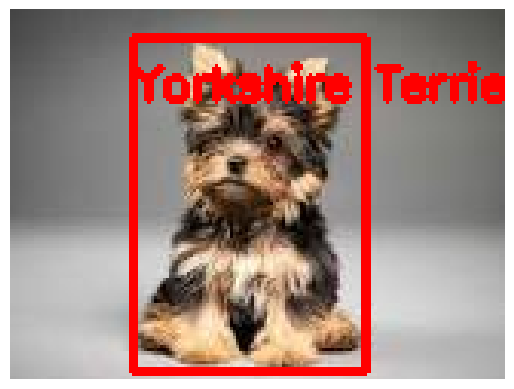

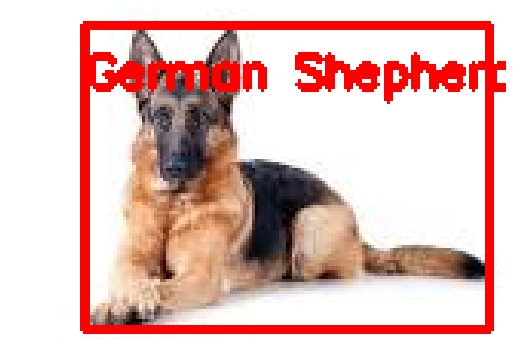

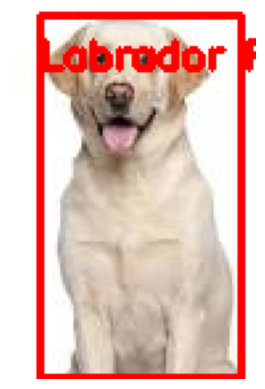

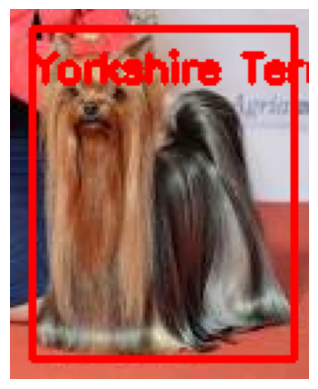

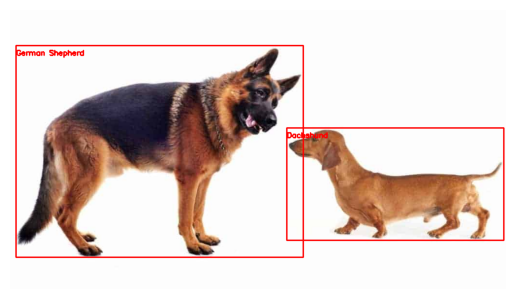

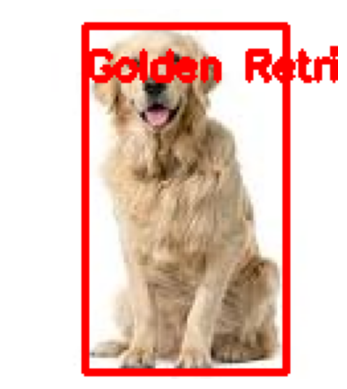

In [58]:
print_random_images(image_paths,n=6 )

Visualizing some pictures from the dataset

## Visualizing Text files for labels

In [ ]:
#import glob
#import xml.etree.ElementTree as ET

df = {'label': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(dataset_path+"/labels/*.txt")):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

In [ ]:
import pandas as pd
train_df = pd.DataFrame(df)
# val_df=pd.DataFrame(df2)
train_df.head()
# val_df.head()

,label,xmin,ymin,xmax,ymax


## Dataset Cleaning

In [59]:
# Get the list of filenames without extensions
image_files = {file.split("/")[-1].split(".")[0] for file in image_paths}
label_files = {file.split("/")[-1].split(".")[0] for file in label_paths}

print(image_files)

{'', 'mixed_15', 'Dachshund_9', 'German Shepherd_40', 'Poodle_23', 'Beagle_20', 'mixed_14', 'mixed_34', 'Rottweiler_31', 'mixed_13', 'Yorkshire Terrier_30', 'Rottweiler_35', 'Golden Retriever_22', 'Rottweiler_13', 'Labrador Retriever_7', 'Dachshund_2', 'Yorkshire Terrier_38', 'mixed_31', 'Beagle_32', 'Boxer_37', 'Boxer_18', 'Poodle_20', 'Beagle_23', 'Bulldog_15', 'mixed_10', 'Dachshund_19', 'Boxer_35', 'Golden Retriever_34', 'Yorkshire Terrier_36', 'Beagle_35', 'German Shepherd_19', 'Rottweiler_26', 'Boxer_40', 'German Shepherd_7', 'Bulldog_28', 'Labrador Retriever_6', 'Yorkshire Terrier_22', 'Golden Retriever_35', 'Dachshund_31', 'Bulldog_20', 'mixed_30', 'Dachshund_39', 'Rottweiler_3', 'Boxer_1', 'Yorkshire Terrier_13', 'Poodle_40', 'Yorkshire Terrier_32', 'Beagle_26', 'Yorkshire Terrier_31', 'Labrador Retriever_3', 'Dachshund_4', 'Labrador Retriever_4', 'Dachshund_28', 'Golden Retriever_7', 'Poodle_38', 'Dachshund_21', 'Beagle_34', 'Poodle_31', 'Boxer_17', 'Boxer_14', 'Labrador Retr

In [60]:
# Find extra files in each folder
extra_images = image_files - label_files
extra_labels = label_files - image_files

# Output the results
print(f"Extra images (without corresponding labels): {extra_images}")
print(f"Extra labels (without corresponding images): {extra_labels}")

Extra images (without corresponding labels): set()
Extra labels (without corresponding images): set()


In [63]:
for file in extra_images:
     os.remove(os.path.join(dataset_path,"images/train", file + '.jpg')) # or '.png' depending on your image format

for file in extra_labels:
     os.remove(os.path.join(dataset_path,"labels/train", file + '.txt'))

Removing them from the dataset:

In [ ]:
os.path.join(dataset_path,"images/train", file + '.jpg')

## **Custom object detection using YOLO**

Pip install ultralytics and dependencies and check software and hardware.

In [81]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.23 🚀 Python-3.11.4 torch-2.5.0 CPU (Apple M2)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 207.9/926.4 GB disk)


In [82]:
from ultralytics import YOLO

## Training YOLO

Select small pretrained (on COCO dataset) model of YOLOv8

In [83]:
model = YOLO('yolov8s.pt') # pretrained model

In [103]:
%%writefile config.yaml
path: /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset
train: /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/train
#test: (test dataset folder path)
val: /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/val

# Classes
nc: 11 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: Golden Retriever
  1: Labrador Retriever
  2: Poodle
  3: Rottweiler
  4: Yorkshire Terrier
  5: Beagle
  6: Boxer
  7: Bulldog
  8: Dachshund
  9: German Shepherd

Overwriting config.yaml


In [104]:
model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.0005,imgsz=640)

New https://pypi.org/project/ultralytics/8.3.24 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.23 🚀 Python-3.11.4 torch-2.5.0 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fals

train: Scanning /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/l

train: WARNING ⚠️ /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/train/mixed_15.jpg: ignoring corrupt image/label: cannot identify image file '/Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/train/mixed_15.jpg'
train: WARNING ⚠️ /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/train/mixed_2.jpg: ignoring corrupt image/label: cannot identify image file '/Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/train/mixed_2.jpg'
train: WARNING ⚠️ /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/train/mixed_36.jpg: ignoring corrupt image/label: cannot identify image file '/Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/train/mixed_36.jpg'
train: WARNING ⚠️ /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/train/mixed_4.jpg: ignoring corrupt image/label: cannot identify image file '/Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images


val: Scanning /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/lab

val: WARNING ⚠️ /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/val/Rottweiler_43.jpg: ignoring corrupt image/label: cannot identify image file '/Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/val/Rottweiler_43.jpg'


val: New cache created: /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/labels/val.cache
Plotting labels to runs/detect/train14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train14
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G     0.8338      3.616      1.337         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        109        121      0.162      0.516      0.235      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G     0.7514      2.459      1.247          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        109        121      0.223      0.549      0.347      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G     0.7602      2.042      1.259         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        109        121       0.37      0.603      0.517      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G     0.7145      1.767       1.21          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        109        121      0.487      0.708      0.691      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G     0.6593       1.54      1.173          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        109        121      0.655      0.805      0.822      0.714



5 epochs completed in 0.349 hours.
Optimizer stripped from runs/detect/train14/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train14/weights/best.pt, 22.5MB

Validating runs/detect/train14/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.11.4 torch-2.5.0 CPU (Apple M2)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        109        121      0.661      0.794      0.823      0.714
      Golden Retriever         14         14      0.634      0.643      0.696      0.566
    Labrador Retriever         14         14       0.49      0.549      0.601      0.456
                Poodle         15         16      0.698      0.875      0.916      0.832
            Rottweiler         11         11      0.528      0.712       0.67      0.558
     Yorkshire Terrier         12         12      0.856       0.99      0.977      0.842
                Beagle         10         10      0.475        0.9      0.914      0.752
                 Boxer         10         10      0.711        0.8      0.852      0.775
               Bulldog         10         10      0.627        0.8      0.864      0.818
             Dachshund         11         11      0.749      0.813      0.805      0.741
       German Shepherd         13         13      0.847      0.854      0.934      0.798
Speed: 0.7ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x323b181d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [105]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.23 🚀 Python-3.11.4 torch-2.5.0 CPU (Apple M2)
Model summary (fused): 168 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/lab

val: WARNING ⚠️ /Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/val/Rottweiler_43.jpg: ignoring corrupt image/label: cannot identify image file '/Users/s.ywg91/Desktop/IAT 360/Computer Vision Project/dataset/images/val/Rottweiler_43.jpg'



                 Class     Images  Instances      Box(P          R      mAP50  m


                   all        109        121      0.684      0.743      0.826      0.717
      Golden Retriever         14         14      0.632      0.615      0.732      0.602
    Labrador Retriever         14         14      0.482      0.429      0.593      0.453
                Poodle         15         16      0.767      0.875      0.923       0.84
            Rottweiler         11         11      0.515      0.677      0.638      0.512
     Yorkshire Terrier         12         12      0.917      0.922      0.989      0.862
                Beagle         10         10      0.504        0.9      0.914      0.754
                 Boxer         10         10      0.776        0.8       0.86      0.782
               Bulldog         10         10      0.634        0.8      0.865        0.8
             Dachshund         11         11      0.842      0.636      0.816      0.779
       German Shepherd         13         13      0.772      0.781      0.934      0.783
Speed: 0.6ms preproce

0.743426530474325

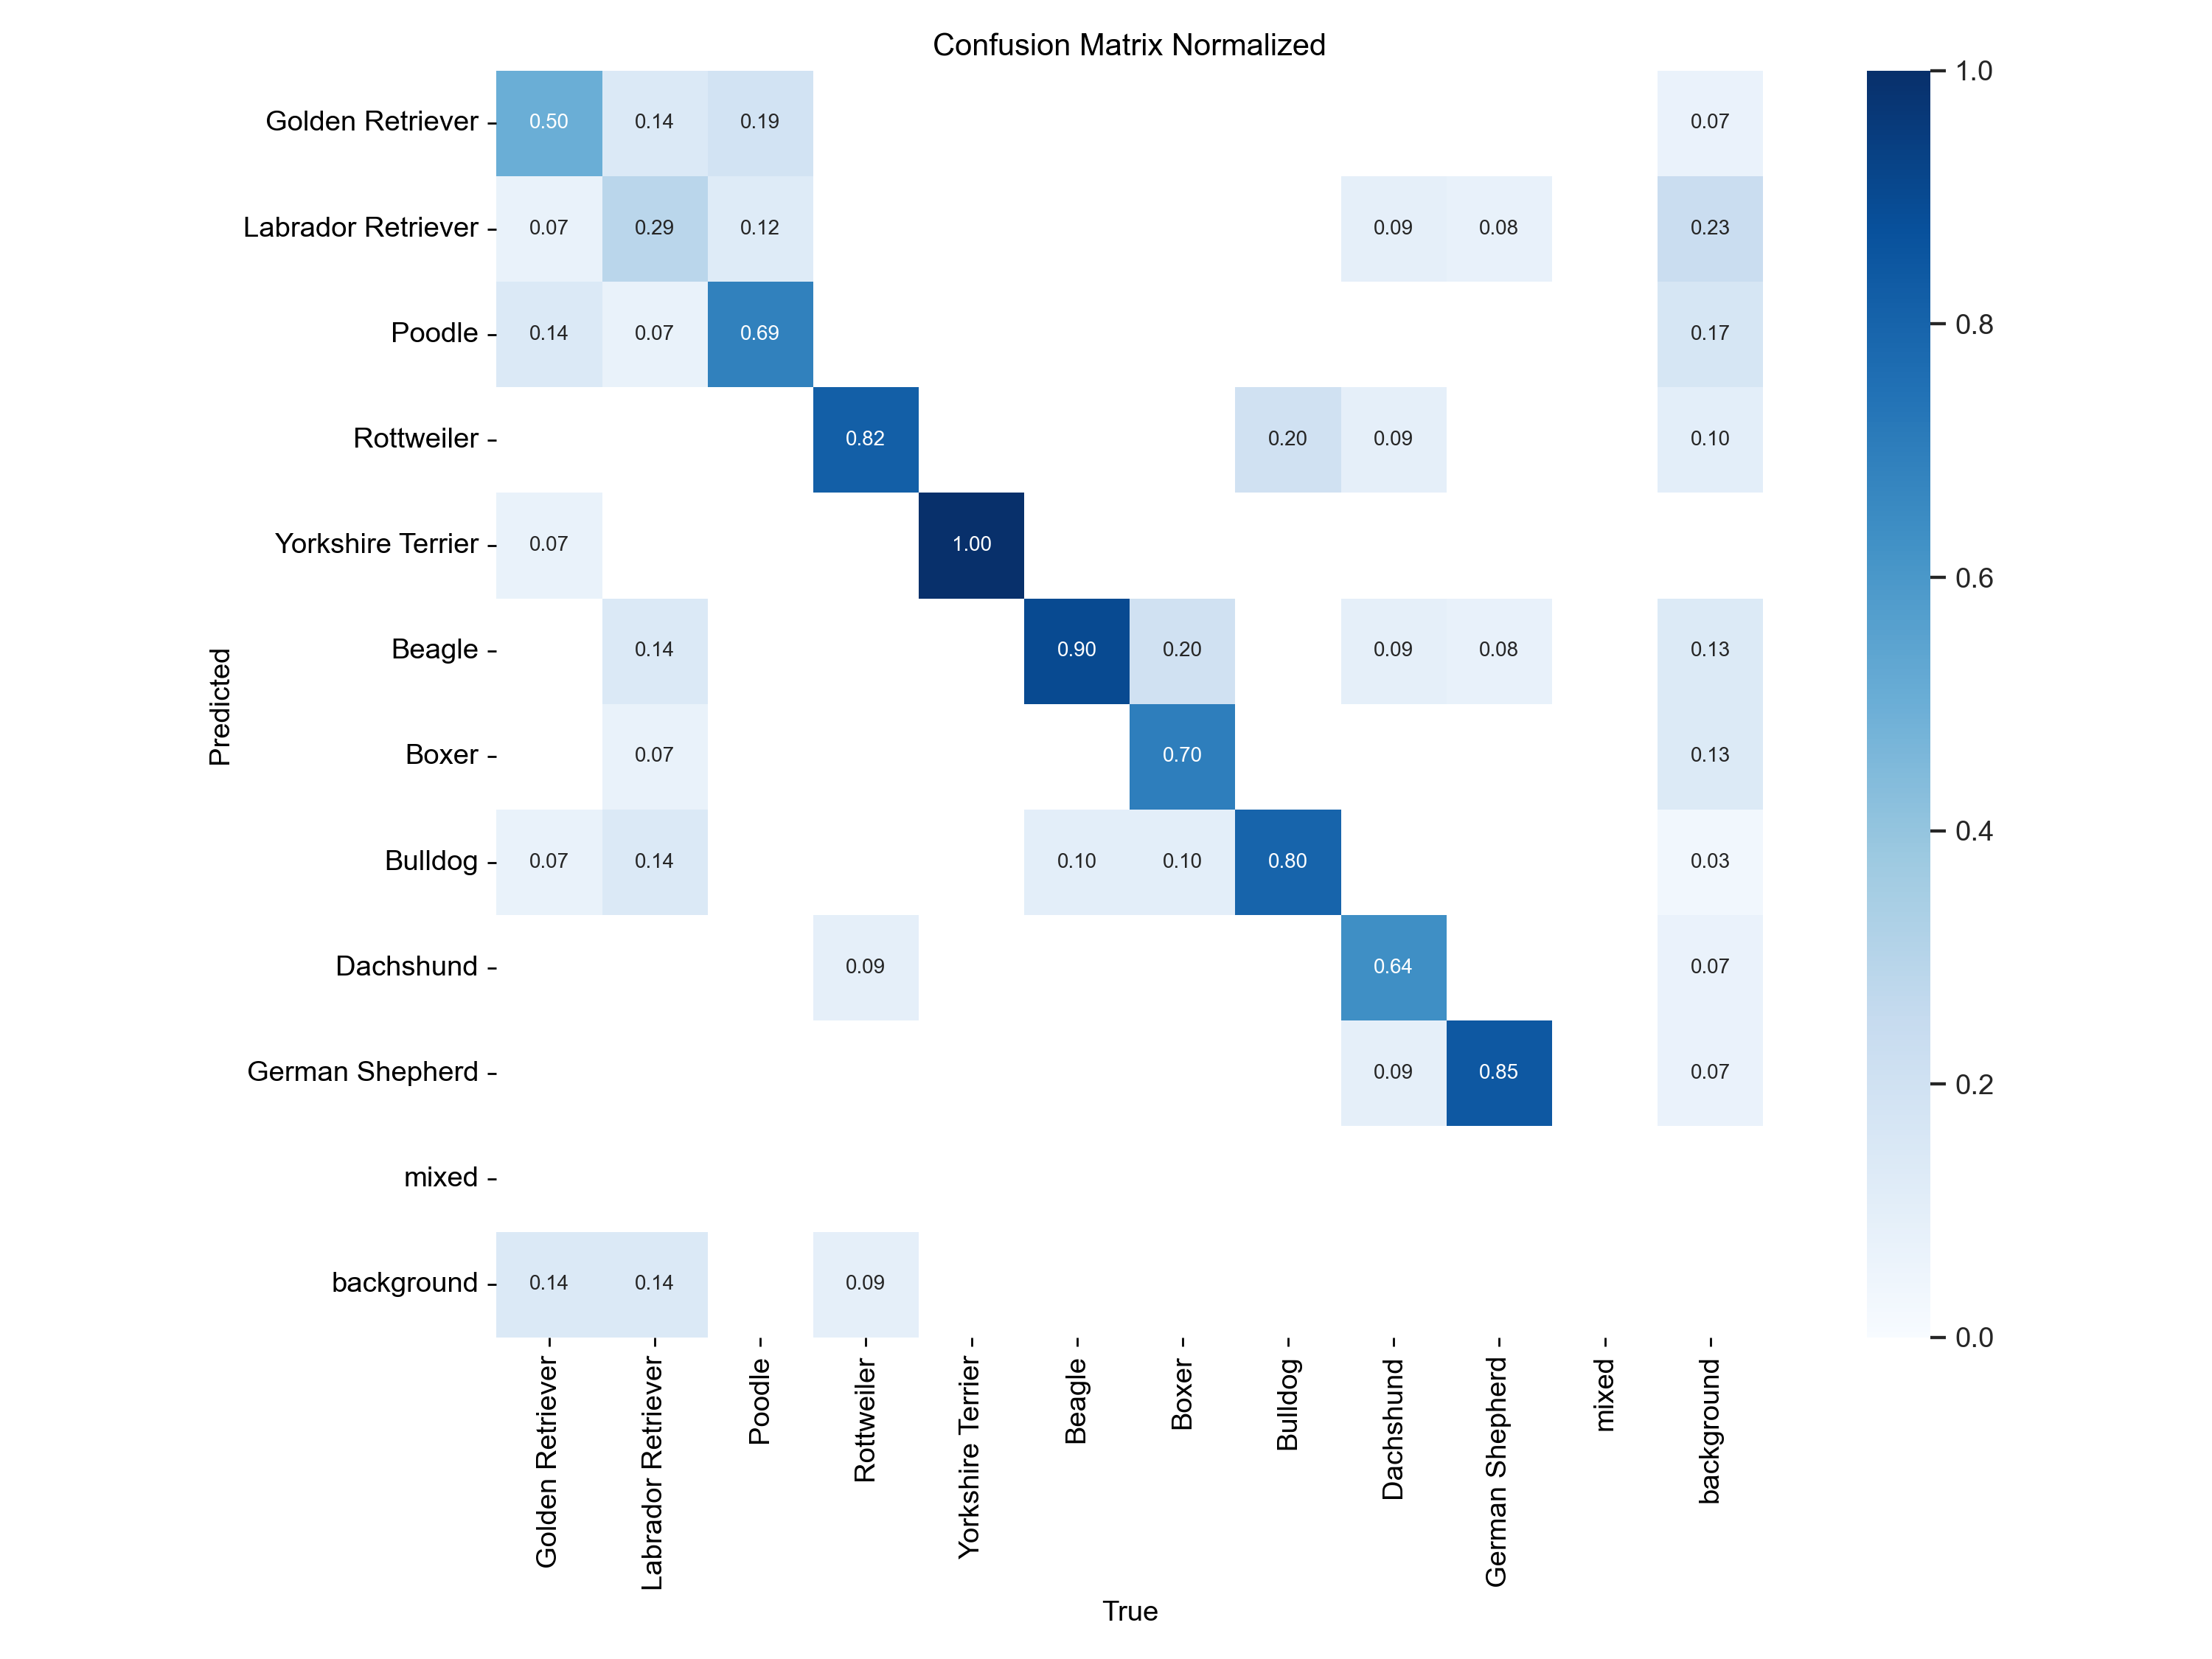

In [107]:
%matplotlib inline
from PIL import Image

Image.open('/Users/s.ywg91/runs/detect/train142/confusion_matrix_normalized.png')